In [1]:
import re, string, gensim, nltk
import pandas as pd
import numpy as np

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

np.random.seed(1234)

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/akhilranjan/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
def preprocess_tweet_text(tweets):
    clean_text = ['']#*len(tweets)
    for tweet in tweets:
        # lowercase text
        tweet = tweet.lower()
        
        # remove urls
        tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
        
        # remove user @ references and '#' from tweet
        tweet = re.sub(r'\@\w+|\#','', tweet)

        # remove punctuations
        tweet = tweet.translate(str.maketrans('', '', string.punctuation))
        
        # remove newline characters and replace with a space
        tweet = tweet.replace('\n',' ')
        
        #print (tweet)
        #print ('-----------------------------------------------------')
        
        clean_text.append(tweet)
        
    # lazy way of returning just the tweets without the first placeholder element
    return clean_text[1:]

stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [3]:
data = pd.read_csv('tweets_15700.csv')

In [4]:
clean_tweets = preprocess_tweet_text(data.text)

In [5]:
doc_sample = clean_tweets[4310] # documents[documents['index'] == 4310].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['sounds', 'about', 'right', 'fuck', 'you', '', '', 'this', 'won’t', 'make', 'up', 'for', 'your', 'covid', 'and', 'flag', 'response', 'in', 'the', 'eyes', 'of', 'the…', '']


 tokenized and lemmatized document: 
['sound', 'right', 'fuck', 'covid', 'flag', 'respons', 'eye']


In [6]:
processed_docs = list(map(preprocess, clean_tweets))

In [7]:
# Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.

dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 covid
1 favorit
2 life
3 outfit
4 pajama
5 stick
6 sure
7 time
8 america
9 asian
10 hispan


In [8]:
# Filter out tokens that appear in
# + less than 15 documents (absolute number) or
# + more than 0.5 documents (fraction of total corpus size, not absolute number).
# + after the above two steps, keep only the first 100000 most frequent tokens.
dictionary.filter_extremes(no_below=15, no_above=0.8, keep_n=100000)

In [9]:
# For each document we create a dictionary reporting how many
#  words and how many times those words appear. Save this to ‘bow_corpus’
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [10]:
bow_doc_4310 = bow_corpus[4310]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
bow_doc_4310[i][1]))

Word 0 ("covid") appears 1 time.
Word 45 ("respons") appears 1 time.
Word 119 ("fuck") appears 1 time.
Word 570 ("right") appears 1 time.
Word 897 ("eye") appears 1 time.
Word 954 ("sound") appears 1 time.


In [11]:
# Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it 
#  to ‘tfidf’, then apply transformation to the entire corpus and call it ‘corpus_tfidf’. 
#  Finally we preview TF-IDF scores for our first document.
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.05028183055775455),
 (1, 0.4740378081631801),
 (2, 0.6476378544250909),
 (3, 0.4783237606213511),
 (4, 0.352890186160401)]


In [12]:
# Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=3, id2word=dictionary, passes=2, workers=2)

In [13]:
# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.143*"covid" + 0.051*"vaccin" + 0.020*"case" + 0.015*"peopl" + 0.015*"death" + 0.010*"think" + 0.010*"report" + 0.009*"coronavirus" + 0.009*"year" + 0.007*"die"
Topic: 1 
Words: 0.088*"covid" + 0.019*"like" + 0.019*"year" + 0.014*"corona" + 0.012*"coronavirus" + 0.011*"relief" + 0.009*"biden" + 0.009*"pandem" + 0.009*"vaccin" + 0.009*"vote"
Topic: 2 
Words: 0.092*"covid" + 0.016*"peopl" + 0.010*"say" + 0.009*"time" + 0.008*"test" + 0.008*"get" + 0.008*"thing" + 0.008*"know" + 0.008*"need" + 0.007*"mask"


In [14]:
# run lda using tf-idf
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=3, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.015*"covid" + 0.012*"test" + 0.011*"corona" + 0.009*"coronavirus" + 0.008*"vaccin" + 0.007*"case" + 0.007*"report" + 0.007*"peopl" + 0.007*"time" + 0.006*"posit"
Topic: 1 Word: 0.039*"covid" + 0.013*"vaccin" + 0.010*"year" + 0.009*"vote" + 0.008*"think" + 0.007*"peopl" + 0.007*"relief" + 0.007*"know" + 0.006*"case" + 0.006*"trump"
Topic: 2 Word: 0.019*"vaccin" + 0.015*"covid" + 0.009*"peopl" + 0.009*"death" + 0.008*"like" + 0.007*"relief" + 0.006*"case" + 0.006*"go" + 0.006*"help" + 0.006*"coronavirus"


In [15]:
data.text[4310]

'Sounds about right... fuck you @tatereeves.\n\nThis won’t make up for your covid and flag response in the eyes of the… https://t.co/Jqv72SAuLo'

In [16]:
processed_docs[4310]

['sound', 'right', 'fuck', 'covid', 'flag', 'respons', 'eye']

In [17]:
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.4764672517776489	 
Topic: 0.088*"covid" + 0.019*"like" + 0.019*"year" + 0.014*"corona" + 0.012*"coronavirus" + 0.011*"relief" + 0.009*"biden" + 0.009*"pandem" + 0.009*"vaccin" + 0.009*"vote"

Score: 0.46907147765159607	 
Topic: 0.143*"covid" + 0.051*"vaccin" + 0.020*"case" + 0.015*"peopl" + 0.015*"death" + 0.010*"think" + 0.010*"report" + 0.009*"coronavirus" + 0.009*"year" + 0.007*"die"

Score: 0.0544612854719162	 
Topic: 0.092*"covid" + 0.016*"peopl" + 0.010*"say" + 0.009*"time" + 0.008*"test" + 0.008*"get" + 0.008*"thing" + 0.008*"know" + 0.008*"need" + 0.007*"mask"


In [18]:
data.text[0]

"@LindenmuthWendi In these times of #COVID19, it seems my favorite outfit is  pajamas.  But I'm not sure I'd stick to that for life."

In [19]:
data.insert(0,'dt_prob',0)
data.insert(0,'topic_num',100)

In [20]:
idx_counter = 0
for t1, t2, t3 in sorted(lda_model_tfidf[bow_corpus], key=lambda tup: -1*tup[1]):
    if (t1[1] > t2[1]) & (t1[1] > t3[1]):
        #print(t1)
        data.loc[idx_counter,'topic_num'] = t1[0]
        data.loc[idx_counter,'dt_prob'] = t1[1]
        idx_counter += 1
    elif (t2[1] > t1[1]) & (t2[1] > t3[1]):
        #print(t2)
        data.loc[idx_counter,'topic_num'] = t2[0]
        data.loc[idx_counter,'dt_prob'] = t2[1]
        idx_counter += 1
    elif (t3[1] > t1[1]) & (t3[1] > t2[1]):
        #print(t3)
        data.loc[idx_counter,'topic_num'] = t3[0]
        data.loc[idx_counter,'dt_prob'] = t3[1]
        idx_counter += 1
    else:
        #print('(-1, {})'.format(t1[1]))
        data.loc[idx_counter,'topic_num'] = -1
        data.loc[idx_counter,'dt_prob'] = t1[1]
        idx_counter += 1
    #print( max(t1, t2, t3))
    #print('~~~~~~~~~~~~~~~')
    #print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

In [21]:
data.topic_num.value_counts()

 1    6324
 2    4615
 0    4592
-1     169
Name: topic_num, dtype: int64

In [22]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [23]:
data.insert(2,'avg_sent_score',0)

In [24]:
for doc_num in range(len(bow_corpus)):
#     print('doc_num: {}'.format(doc_num))
    doc = bow_corpus[doc_num]
    avg_sent_score = 0
    for i in range(len(doc)):
#         print('\tword {} (\"{}\") appears {} time'.format(doc[i][0],
#                                                        dictionary[doc[i][0]],
#                                                        doc[i][1]))
#         print('{} sentiment score: {}'.format(dictionary[doc[i][0]], 
#                                              sia.polarity_scores(dictionary[doc[i][0]])['compound']))
        avg_sent_score = avg_sent_score + sia.polarity_scores(dictionary[doc[i][0]])['compound']
    if not len(doc)==0:
        avg_sent_score = avg_sent_score/len(doc)
        data.loc[doc_num,'avg_sent_score'] = avg_sent_score
# compound is overall sentiment score

In [25]:
np.round(data.groupby('topic_num').avg_sent_score.describe(),4)

,count,mean,std,min,25%,50%,75%,max
topic_num,,,,,,,,
-1,169.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000
0,4592.0,0.0022,0.0841,-0.6908,0.0000,0.0,0.0305,0.5994
1,6324.0,0.0004,0.0757,-0.5574,0.0000,0.0,0.0000,0.6369
2,4615.0,0.0038,0.0820,-0.5719,-0.0155,0.0,0.0398,0.6249


In [26]:
data.groupby('topic_num').avg_sent_score.mean()

topic_num
-1    0.000000
 0    0.002248
 1    0.000413
 2    0.003774
Name: avg_sent_score, dtype: float64

In [27]:
# get top 30 words per topic and store in dataframe
x = lda_model_tfidf.show_topics(num_topics=3, num_words=30, formatted=False)

t0 = x[0][1]
t1 = x[1][1]
t2 = x[2][1]

t0 = [[ i for i, j in t0 ], 
      [ j for i, j in t0 ]]

t1 = [[ i for i, j in t1 ], 
      [ j for i, j in t1 ]]

t2 = [[ i for i, j in t2 ], 
      [ j for i, j in t2 ]]

top_words = pd.DataFrame([t0[0],t0[1], t1[0],t1[1], t2[0],t2[1]]).T
top_words.columns = ['topic 0 words','topic 0 weights',
                    'topic 1 words','topic 1 weights',
                    'topic 2 words','topic 2 weights']

In [28]:
top_words

,topic 0 words,topic 0 weights,topic 1 words,topic 1 weights,topic 2 words,topic 2 weights
0,covid,0.015201,covid,0.038582,vaccin,0.018779
1,test,0.012464,vaccin,0.013352,covid,0.015438
2,corona,0.010928,year,0.010453,peopl,0.009208
3,coronavirus,0.008528,vote,0.008742,death,0.008695
4,vaccin,0.007767,think,0.008082,like,0.008078
5,case,0.00724,peopl,0.007285,relief,0.006605
6,report,0.007014,relief,0.006931,case,0.006496
7,peopl,0.006999,know,0.0066,go,0.005995
8,time,0.006641,case,0.006324,help,0.005594
9,posit,0.00629,trump,0.006144,coronavirus,0.005524


/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


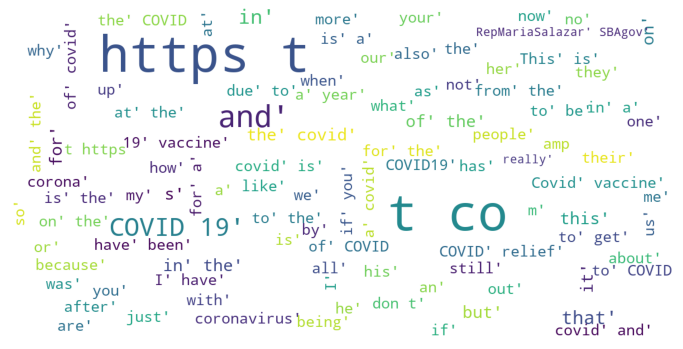

In [56]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

In [66]:
type(clean_tweets)

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


list

In [70]:
data['clean_tweets']=pd.DataFrame(pd.Series(clean_tweets))

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
data

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_num,dt_prob,avg_sent_score,username,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,pol_sub,Polarity,Subjectivity,Sentiment,clean_tweets
0,2,0.814672,0.063640,GillianMKendall,NaN,7354,7400,24122,5/26/14 13:05,3/14/21 18:30,0,"@LindenmuthWendi In these times of #COVID19, i...","[{'text': 'COVID19', 'indices': [35, 43]}]","(0.125, 0.9444444444444444)",0.125000,0.944444,positive,in these times of covid19 it seems my favorit...
1,1,0.847489,-0.128300,blxckreject,NaN,197,61,1518,12/31/20 10:58,3/14/21 18:30,0,Reminder that asians and Hispanics are also vi...,[],"(0.0, 0.0)",0.000000,0.000000,neutral,reminder that asians and hispanics are also vi...
2,1,0.854007,-0.119175,guilfordghost,NaN,127,17,1079,1/20/21 17:19,3/14/21 18:30,0,@vlindy33 @biannagolodryga @maggieNYT @CNNMeri...,[],"(0.0, 0.0)",0.000000,0.000000,neutral,my point is to say that kids behavioral is...
3,2,0.670358,0.000000,Rickself27gmai1,Pittsburgh,4971,4337,2311,3/12/18 11:54,3/14/21 18:30,0,No Saying Much for Christie but All of the Rep...,[],"(0.2, 0.2)",0.200000,0.200000,positive,no saying much for christie but all of the rep...
4,1,0.531789,0.000000,CovidData2,NaN,31,83,12948,4/5/20 14:41,3/14/21 18:30,0,New COVID-19 Data at 2021-03-14 02:30:00 pm ED...,"[{'text': 'Coronavirus', 'indices': [48, 60]},...","(0.13636363636363635, 0.45454545454545453)",0.136364,0.454545,positive,new covid19 data at 20210314 023000 pm edt cor...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15695,1,0.894024,-0.063633,djvlad,New York,863,166074,241380,12/12/08 22:43,3/14/21 17:25,10,Marvin Hagler Was Allegedly in ICU Fighting Af...,[],"(-0.1, 0.1)",-0.100000,0.100000,negative,marvin hagler was allegedly in icu fighting af...
15696,1,0.836081,0.000000,NumbersMan3,NaN,3,23,4014,4/25/20 14:49,3/14/21 17:25,0,"@jdpoc Or, to paraphrase: know your rights and...",[],"(0.0, 0.0)",0.000000,0.000000,neutral,or to paraphrase know your rights and ignore ...
15697,1,0.670566,0.042500,EwanKing_,NaN,1489,475,3856,9/18/13 15:18,3/14/21 17:25,0,Baffling how the SFA are planning on making pa...,[],"(-0.3333333333333333, 0.6666666666666666)",-0.333333,0.666667,negative,baffling how the sfa are planning on making pa...
15698,0,0.496557,-0.054543,Mix1041,"Boston, MA",3457,14016,61104,8/7/09 15:54,3/14/21 17:25,0,"As more nursing home residents get vaccinated,...",[],"(0.5, 0.5)",0.500000,0.500000,positive,as more nursing home residents get vaccinated ...


In [72]:
from textblob import TextBlob

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
def sentiment_func(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
data['pol_sub']=data['clean_tweets'].apply(sentiment_func)

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
data['pol_sub'][0][0]

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.125

In [76]:
data['Polarity'] = data['pol_sub'].apply(lambda x: x[0])
data['Subjectivity'] = data['pol_sub'].apply(lambda x: x[1])

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
data

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_num,dt_prob,avg_sent_score,username,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,pol_sub,Polarity,Subjectivity,Sentiment,clean_tweets
0,2,0.814672,0.063640,GillianMKendall,NaN,7354,7400,24122,5/26/14 13:05,3/14/21 18:30,0,"@LindenmuthWendi In these times of #COVID19, i...","[{'text': 'COVID19', 'indices': [35, 43]}]","(0.125, 0.9444444444444444)",0.125000,0.944444,positive,in these times of covid19 it seems my favorit...
1,1,0.847489,-0.128300,blxckreject,NaN,197,61,1518,12/31/20 10:58,3/14/21 18:30,0,Reminder that asians and Hispanics are also vi...,[],"(0.0, 0.0)",0.000000,0.000000,neutral,reminder that asians and hispanics are also vi...
2,1,0.854007,-0.119175,guilfordghost,NaN,127,17,1079,1/20/21 17:19,3/14/21 18:30,0,@vlindy33 @biannagolodryga @maggieNYT @CNNMeri...,[],"(0.0, 0.0)",0.000000,0.000000,neutral,my point is to say that kids behavioral is...
3,2,0.670358,0.000000,Rickself27gmai1,Pittsburgh,4971,4337,2311,3/12/18 11:54,3/14/21 18:30,0,No Saying Much for Christie but All of the Rep...,[],"(0.2, 0.2)",0.200000,0.200000,positive,no saying much for christie but all of the rep...
4,1,0.531789,0.000000,CovidData2,NaN,31,83,12948,4/5/20 14:41,3/14/21 18:30,0,New COVID-19 Data at 2021-03-14 02:30:00 pm ED...,"[{'text': 'Coronavirus', 'indices': [48, 60]},...","(0.13636363636363635, 0.45454545454545453)",0.136364,0.454545,positive,new covid19 data at 20210314 023000 pm edt cor...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15695,1,0.894024,-0.063633,djvlad,New York,863,166074,241380,12/12/08 22:43,3/14/21 17:25,10,Marvin Hagler Was Allegedly in ICU Fighting Af...,[],"(-0.1, 0.1)",-0.100000,0.100000,negative,marvin hagler was allegedly in icu fighting af...
15696,1,0.836081,0.000000,NumbersMan3,NaN,3,23,4014,4/25/20 14:49,3/14/21 17:25,0,"@jdpoc Or, to paraphrase: know your rights and...",[],"(0.0, 0.0)",0.000000,0.000000,neutral,or to paraphrase know your rights and ignore ...
15697,1,0.670566,0.042500,EwanKing_,NaN,1489,475,3856,9/18/13 15:18,3/14/21 17:25,0,Baffling how the SFA are planning on making pa...,[],"(-0.3333333333333333, 0.6666666666666666)",-0.333333,0.666667,negative,baffling how the sfa are planning on making pa...
15698,0,0.496557,-0.054543,Mix1041,"Boston, MA",3457,14016,61104,8/7/09 15:54,3/14/21 17:25,0,"As more nursing home residents get vaccinated,...",[],"(0.5, 0.5)",0.500000,0.500000,positive,as more nursing home residents get vaccinated ...


In [78]:
from textblob import TextBlob
def get_tweet_sentiment(text):
        analysis = TextBlob(text)
        if analysis.sentiment.polarity > 0:
            return 'positive'
        elif analysis.sentiment.polarity == 0:
            return 'neutral'
        else:
            return 'negative'

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:
data['Sentiment'] = data['clean_tweets'].apply(get_tweet_sentiment)

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [80]:
data

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_num,dt_prob,avg_sent_score,username,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,pol_sub,Polarity,Subjectivity,Sentiment,clean_tweets
0,2,0.814672,0.063640,GillianMKendall,NaN,7354,7400,24122,5/26/14 13:05,3/14/21 18:30,0,"@LindenmuthWendi In these times of #COVID19, i...","[{'text': 'COVID19', 'indices': [35, 43]}]","(0.125, 0.9444444444444444)",0.125000,0.944444,positive,in these times of covid19 it seems my favorit...
1,1,0.847489,-0.128300,blxckreject,NaN,197,61,1518,12/31/20 10:58,3/14/21 18:30,0,Reminder that asians and Hispanics are also vi...,[],"(0.0, 0.0)",0.000000,0.000000,neutral,reminder that asians and hispanics are also vi...
2,1,0.854007,-0.119175,guilfordghost,NaN,127,17,1079,1/20/21 17:19,3/14/21 18:30,0,@vlindy33 @biannagolodryga @maggieNYT @CNNMeri...,[],"(0.0, 0.0)",0.000000,0.000000,neutral,my point is to say that kids behavioral is...
3,2,0.670358,0.000000,Rickself27gmai1,Pittsburgh,4971,4337,2311,3/12/18 11:54,3/14/21 18:30,0,No Saying Much for Christie but All of the Rep...,[],"(0.2, 0.2)",0.200000,0.200000,positive,no saying much for christie but all of the rep...
4,1,0.531789,0.000000,CovidData2,NaN,31,83,12948,4/5/20 14:41,3/14/21 18:30,0,New COVID-19 Data at 2021-03-14 02:30:00 pm ED...,"[{'text': 'Coronavirus', 'indices': [48, 60]},...","(0.13636363636363635, 0.45454545454545453)",0.136364,0.454545,positive,new covid19 data at 20210314 023000 pm edt cor...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15695,1,0.894024,-0.063633,djvlad,New York,863,166074,241380,12/12/08 22:43,3/14/21 17:25,10,Marvin Hagler Was Allegedly in ICU Fighting Af...,[],"(-0.1, 0.1)",-0.100000,0.100000,negative,marvin hagler was allegedly in icu fighting af...
15696,1,0.836081,0.000000,NumbersMan3,NaN,3,23,4014,4/25/20 14:49,3/14/21 17:25,0,"@jdpoc Or, to paraphrase: know your rights and...",[],"(0.0, 0.0)",0.000000,0.000000,neutral,or to paraphrase know your rights and ignore ...
15697,1,0.670566,0.042500,EwanKing_,NaN,1489,475,3856,9/18/13 15:18,3/14/21 17:25,0,Baffling how the SFA are planning on making pa...,[],"(-0.3333333333333333, 0.6666666666666666)",-0.333333,0.666667,negative,baffling how the sfa are planning on making pa...
15698,0,0.496557,-0.054543,Mix1041,"Boston, MA",3457,14016,61104,8/7/09 15:54,3/14/21 17:25,0,"As more nursing home residents get vaccinated,...",[],"(0.5, 0.5)",0.500000,0.500000,positive,as more nursing home residents get vaccinated ...


#### Plotting the polarity of the tweets

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<BarContainer object of 1212 artists>

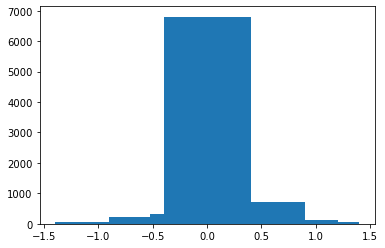

In [81]:
plt.bar(data.Polarity.value_counts().index,
        data.Polarity.value_counts())

#### Plotting the sentiment of the tweets

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<BarContainer object of 3 artists>

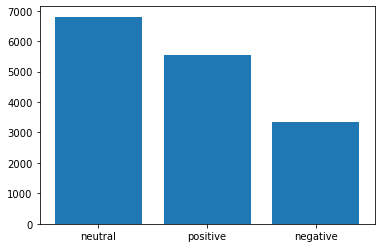

In [82]:
plt.bar(data.Sentiment.value_counts().index,
        data.Sentiment.value_counts())

#### The length of tweets

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

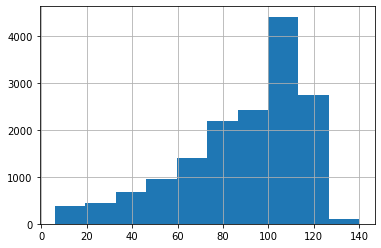

In [83]:
data['clean_tweets'].str.len().hist()

#### The average word length of tweets

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

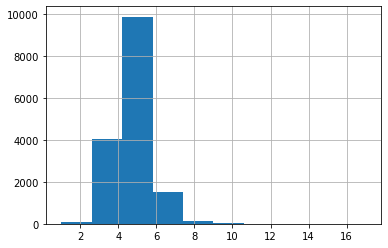

In [84]:
data['clean_tweets'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

In [85]:
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
stop=set(stopwords.words('english'))

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
corpus=[]
new= data['clean_tweets'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Stop words that occur in the tweets

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<BarContainer object of 10 artists>

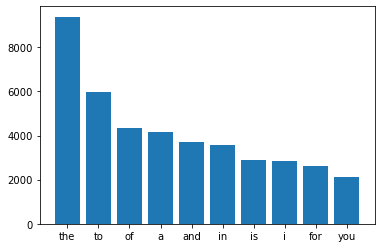

In [90]:
from matplotlib import pyplot as plt
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

In [91]:
import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Words other than stop words that frequently occur in the tweets

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


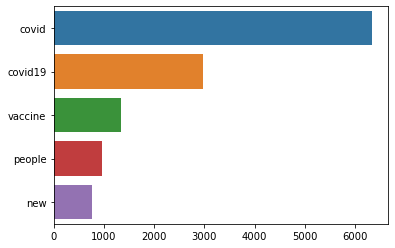

In [92]:
plot_top_non_stopwords_barchart(data['clean_tweets'])

In [93]:
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim


def get_lda_objects(text):
    nltk.download('stopwords')    
    stop=set(stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### LDA visualisation: allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar

In [94]:
lda_model, bow_corpus, dic = get_lda_objects(data['clean_tweets'])

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akhilranjan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [95]:
lda_model.show_topics()

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.036*"covid19" + 0.015*"covid" + 0.011*"vaccine" + 0.006*"pandemic" + 0.005*"world" + 0.005*"vaccination" + 0.004*"people" + 0.004*"via" + 0.004*"check" + 0.004*"corona"'),
 (1,
  '0.058*"covid" + 0.012*"people" + 0.009*"vaccine" + 0.008*"covid19" + 0.007*"like" + 0.006*"get" + 0.006*"day" + 0.006*"amp" + 0.005*"due" + 0.005*"would"'),
 (2,
  '0.041*"covid" + 0.016*"covid19" + 0.015*"new" + 0.011*"case" + 0.011*"relief" + 0.011*"vaccine" + 0.010*"coronavirus" + 0.010*"death" + 0.008*"bill" + 0.007*"year"')]

In [96]:
plot_lda_vis(lda_model, bow_corpus, dic)

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.130920  0.072609       1        1  40.041393
2      0.003099 -0.140294       2        1  31.579172
0     -0.134020  0.067685       3        1  28.379435, topic_info=            Term         Freq        Total Category  logprob  loglift
40           new   663.000000   663.000000  Default  30.0000  30.0000
0        covid19  2570.000000  2570.000000  Default  29.0000  29.0000
94        relief   494.000000   494.000000  Default  28.0000  28.0000
268         bill   367.000000   367.000000  Default  27.0000  27.0000
151         case   647.000000   647.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
294          one   121.504401   553.427147   Topic3  -5.7818  -0.2567
208         year   122.656536   659.406205   Topic3  -5.7723  -0.4224
880          see    91.294167   254.371131   Topic3  -6.0676   0.2348
765       school    79.547781   192.592610   Topic3  -6.2054   0.3753
37   coronavirus    84.067147   577.564147   Topic3  -6.1501  -0.6677

[221 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2448      2  0.983867       384
6211      1  0.990648    affect
267       1  0.011244  american
267       2  0.691535  american
267       3  0.297979  american
...     ...       ...       ...
991       2  0.045988     would
991       3  0.009855     would
208       1  0.373063      year
208       2  0.439790      year
208       3  0.186531      year

[326 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

/Users/akhilranjan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


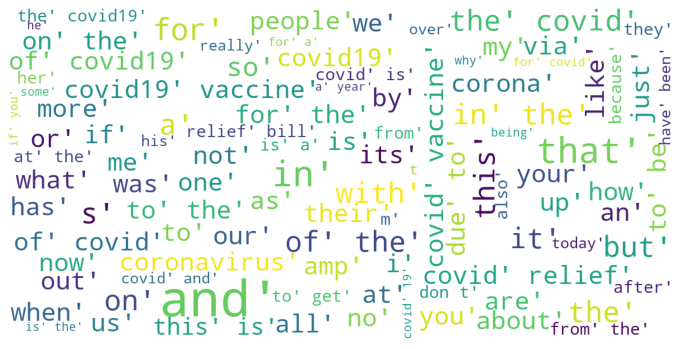

In [97]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)